In [1]:
#import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier # KNN Neighbours
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Algo
from sklearn.svm import LinearSVC # Linear SVM
from sklearn.metrics import confusion_matrix,auc,roc_auc_score,f1_score # Metrics for understading model
from sklearn.preprocessing import StandardScaler # Standardize features by removing the mean and scaling to unit variance
from sklearn.model_selection import train_test_split # Split arrays or matrices into random train and test subsets
from sklearn.model_selection import RandomizedSearchCV # Randomized search on hyper parameters #can be used to tune parameters
from sklearn.feature_extraction.text import TfidfVectorizer # Convert a collection of raw documents to a matrix of TF-IDF features
# TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents
from scikitplot.metrics import plot_confusion_matrix # Plot Confusion Matrix
from tqdm import tqdm # https://www.geeksforgeeks.org/python-how-to-make-a-terminal-progress-bar-using-tqdm/
import re
from bs4 import BeautifulSoup # Beautiful Soup is a Python library for pulling data out of HTML and XML files. 
# It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree.
%matplotlib inline
import warnings # https://docs.python.org/3/library/warnings.html
from sklearn.utils import shuffle as shuffle # to shuffle data and avoid bias
warnings.simplefilter(action='ignore', category=FutureWarning) 
from wordcloud import WordCloud # Word Cloud is a data visualization technique used for representing text data in which
# the size of each word indicates its frequency or importance
# https://www.geeksforgeeks.org/generating-word-cloud-python/

In [2]:
#read the data
reviews = pd.read_csv("SentimentAnalysis/Reviews.csv")
#print(len(reviews)) # 568454
#type(reviews) #data frame
reviews = reviews[:50000] #5 lakh reviews is too much for system to handle--> Big Data --> Clustered EC2 could have helped
reviews = shuffle(reviews).reset_index(drop=True) #remove data creation bias and drop index and recreate it
reviews.head(n=5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,13217,B005CGUUNE,A3T1HPEXOLF78Q,KittyProximity,0,0,5,1329350400,Can't get enough,My cat loves these! When I take the container ...
1,32952,B001P05K8Q,A1ELC7PAS527RP,doodles,0,0,4,1338940800,Cet hextra premium oral hygiene chews,"Great price and Quick delivery. However, the ..."
2,45944,B0041NYV8E,ACVDL5QRCOPE1,D. H.,0,0,2,1342915200,I litterally gagged on this stuff,"I am a big fan of herbal teas, but when my sto..."
3,18882,B000F4H5FY,A3NNO6Z52KV5PQ,Dawn R. Casseday,0,0,5,1265155200,"if you like strong, black tea.... this is for you",This is a blend of black teas. Some are more ...
4,22174,B000KV61FC,A3GK4K5VB4UT47,Denise E. Seisler,3,3,5,1257724800,Wonderful attention Keeper!,This toy is perfect for my Min Pin. He works ...


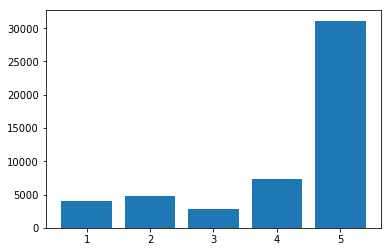

In [3]:
#Understanding initial data
plt.bar(reviews["Score"].unique(),reviews["Score"].value_counts())
plt.xticks([1,2,3,4,5]) # initial bias of data towards 5* that is +ve review
plt.show() 

In [4]:
#converting  sccores to three labels -1,0,1 for , negative(score<3),Positive(score=5),neutral(score==3 or 4)
def label(x):
    if x==5:
        return 1  #1
    elif x<3:
        return -1 #0
    else:
        return 0  #2
reviews["Score"]=reviews["Score"].map(label)
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,13217,B005CGUUNE,A3T1HPEXOLF78Q,KittyProximity,0,0,1,1329350400,Can't get enough,My cat loves these! When I take the container ...
1,32952,B001P05K8Q,A1ELC7PAS527RP,doodles,0,0,0,1338940800,Cet hextra premium oral hygiene chews,"Great price and Quick delivery. However, the ..."
2,45944,B0041NYV8E,ACVDL5QRCOPE1,D. H.,0,0,-1,1342915200,I litterally gagged on this stuff,"I am a big fan of herbal teas, but when my sto..."
3,18882,B000F4H5FY,A3NNO6Z52KV5PQ,Dawn R. Casseday,0,0,1,1265155200,"if you like strong, black tea.... this is for you",This is a blend of black teas. Some are more ...
4,22174,B000KV61FC,A3GK4K5VB4UT47,Denise E. Seisler,3,3,1,1257724800,Wonderful attention Keeper!,This toy is perfect for my Min Pin. He works ...


In [5]:
# data is having duplicate values ?
# An important part of Data analysis is analyzing Duplicate Values and removing them. 
# Pandas duplicated() method helps in analyzing duplicate values only. 
# It returns a boolean series which is True only for Unique elements

reviews[reviews[["UserId","ProfileName","Time","Text"]].duplicated()]

# 2478 rows × 10 columns are duplicates might vary depending on shuffled data subset

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1071,28477,B0016FRI8A,A15D65M0NGF1T,Veebee,0,0,1,1275436800,Love it!,I drink this delicious tea almost every day. ...
1170,17927,B008ZRKZSM,A2RQGZHGM7SXRC,Jessers,1,1,1,1340236800,YUM!,I'm on Weight Watchers but I loooove peanut bu...
1547,544,B000G6RYNE,A3GJQ3W0T0KWEO,"tatcol ""tatcol""",0,2,-1,1328918400,USED to be my favorite chips,"Kettle Brand chips used to be so good...oily, ..."
1913,18849,B0007ZPY2C,A1TMNIGFVJ32JL,J. Schwartz,2,2,1,1204934400,The Only Thing Better Than . . .,"Jablum Jamaican coffee is Jamaica itself, espe..."
1939,23892,B0013NUGDE,AKU6UCK068L9H,Eleni Fredlund,0,0,0,1318723200,not as good as BBQ flavor,BBQ was out-of-stock when our subscription ord...
2022,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,-1,1127606400,Below standard,Too much of the white pith on this orange peel...
2045,26023,B0058AMY74,ACFPHOYVB71V4,karob,0,0,1,1292630400,BEST BUY in BBQ Chips,Tried many varieties of BBQ chips and hands do...
2101,25442,B0051TPWUI,AM9LRYG6YXV83,"P. Verkhovensky ""uebermensch""",5,5,1,1212451200,"Unique product, well executed",The flavor of these nuts is similar to cinnamo...
2278,38225,B0027UQYZQ,A2803KK3ZW27FC,bec10,1,4,0,1289779200,Lid was chipped but I like the product,Came to me with a chipped lid. I wrote an ema...
2378,13593,B005WIO4CU,A2BN0ZQ947XJ64,Sarah Krueger,0,0,1,1337472000,Delicious,"The smell alone will make you salivate, it is ..."


In [6]:
# Since there are duplicates in our data. Lets drop all of them # Pre Processing
print("Data set size before dropping duplicates",reviews.shape)
reviews_df = reviews.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first')
print("Data set size after dropping duplicates",reviews_df.shape)

Data set size before dropping duplicates (50000, 10)
Data set size after dropping duplicates (46268, 10)


In [7]:
# Analyzing missing values
# Text is our feature and score is our label.
reviews_df[["Text","Score"]].isnull().any()

Text     False
Score    False
dtype: bool

In [8]:
# For analysis, we only need score and text 
#  	Id 	ProductId 	UserId 	ProfileName 	HelpfulnessNumerator 	HelpfulnessDenominator 	Time 	Summary NOT required
reviews_df=reviews_df[["Text","Score"]] 
print(reviews_df.head())
print(reviews_df["Text"][0])
print(len(reviews_df["Text"][0]))

                                                Text  Score
0  My cat loves these! When I take the container ...      1
1  Great price and Quick delivery.  However, the ...      0
2  I am a big fan of herbal teas, but when my sto...     -1
3  This is a blend of black teas.  Some are more ...      1
4  This toy is perfect for my Min Pin.  He works ...      1
My cat loves these! When I take the container out, she get super excited and eats every last flake I give her. She's a very picky eater, and I've never seen her so happy with a treat before.
190


In [9]:
print("Amount of data retianed is : ", reviews_df.shape[0]/reviews.shape[0]) #getting data retained

Amount of data retianed is :  0.92536


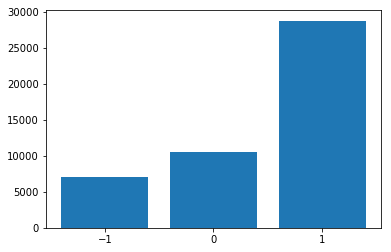

In [10]:
plt.bar(reviews_df["Score"].unique(),reviews_df["Score"].value_counts())
plt.xticks([-1,0,1])
plt.show() 
# -1, 0 then 1 increasing order of count

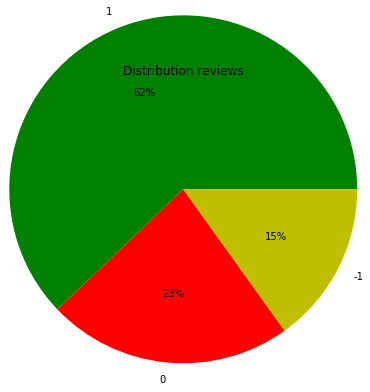

In [11]:
value_counts=reviews_df["Score"].value_counts() #getting count of individual label
radius=2 #size of plot
labels=reviews_df["Score"].unique() #labels for plot
colors=["g","r","y"] #A sequence of matplotlib color args through which the pie chart will cycle. 
plt.pie(value_counts,autopct='%1.0f%%',radius=radius,labels=labels,colors=colors)
plt.title("Distribution reviews")
plt.show()

#### Observations:
1. After removing duplicates and missing values we were able to retain 94% of actual data(varies across runs).
2. From the above bar,pie plot we can clearly see that our data is imbalanced, biased towards to class 0(Neutral).

# 3. Removing unwanted charachter, stop words

Though we removed noise data, we need to make sure that our data is clean
with text data comes a lot of unwanted characters, symbols, numbers and common words which adds no value to the model's performance
so we will try to remove these unwanted characters to get a clean data


In [12]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(reviews_df.shape)

(46268, 2)


In [13]:
print(stop_words)

{'over', "weren't", "needn't", 'shan', 'me', 'some', 'yourself', 'itself', 'hasn', 'my', 'no', 'there', 'were', 'mightn', 'hers', 'on', 'should', 'wasn', 'can', 'themselves', 'and', 'been', 'few', 'o', 'before', 'your', "aren't", 'against', 'he', 'you', 'in', 'just', 'now', 'her', 'weren', 'was', 'it', 'from', 'off', 'once', 'or', 'until', "shan't", 'this', "couldn't", "mightn't", 'more', 'but', 'as', 'couldn', 've', "you've", 'a', 'all', 'own', 'll', 'mustn', 'than', 'is', 's', 'we', 'his', 'herself', 'them', 'what', 'aren', 'not', 'each', 'into', "doesn't", 'how', 'other', 'doesn', 'yours', 'out', "you'd", 'their', 'nor', 'have', "should've", 'the', 'these', "mustn't", 'such', 'myself', "she's", "hasn't", "hadn't", "shouldn't", 'ourselves', 'here', 'during', 'wouldn', 'where', "don't", 'they', 're', "wasn't", 'very', 'to', 'needn', 'between', 'those', 'by', 'do', 'because', "you'll", 'am', 'our', 'same', 'only', 'did', 'so', 'yourselves', 'under', 'i', 'does', 'ours', 'isn', 'most', 

In [14]:
#remove word not from stop words, since it is important word in classifing the review. # stanford lectures
stop_words.remove("not")
print(len(stop_words))

178


In [15]:
def text_Preprocessing(reviews):
    """ This will :
    1. clean the text data
    2. remove html tags
    3. remove special characters
    4. then tokenize the reviews to apply Stemmer on each word token."""
    
    pre_processed_reviews=[] # list
    
    for review in tqdm(reviews):
        review= BeautifulSoup(review,'lxml').getText()    #remove html tags
        review=re.sub('\S*\d\S*','',review).strip()
        review=re.sub("n't","not",review)           #convert n't(s) to not(s) before removing any special char and numbers
        review=re.sub('[^A-Za-z]+',' ',review)        #remove special chars
        review=word_tokenize(str(review.lower())) #tokenize the reviews into word tokens

        # split the review into constituents words  
        # if stop word remove it
        review=' '.join(PorterStemmer().stem(word) for word in review if word not in stop_words)
        pre_processed_reviews.append(review.strip())
    return pre_processed_reviews

In [16]:
preprocessed_reviews=text_Preprocessing(reviews_df["Text"])
print(preprocessed_reviews[0])
print(len(preprocessed_reviews[0]))


100%|██████████| 46268/46268 [01:16<00:00, 604.44it/s]

cat love take contain get super excit eat everi last flake give picki eater never seen happi treat
98


In [17]:
#convert list to data frame add back score as sentiment
preprocessed_reviews=pd.DataFrame({"text":preprocessed_reviews,"sentiment":reviews_df.Score})
preprocessed_reviews.head()

,sentiment,text
0,1,cat love take contain get super excit eat ever...
1,0,great price quick deliveri howev packag poorli...
2,-1,big fan herbal tea stomach feel sick rememb bo...
3,1,blend black tea mild other good deal money
4,1,toy perfect min pin work get kibbl good minut


In [18]:
print(preprocessed_reviews.sentiment.value_counts())
print(type(preprocessed_reviews.sentiment))

 1    28751
 0    10528
-1     6989
Name: sentiment, dtype: int64
<class 'pandas.core.series.Series'>


So far:
1. cleaned text data, removed tags, n'ts to not 
2. Though data is cleaned, it is still in string format which computers won't understand(NLP), for this we use text featuration.

### 3.1.Featurization

In [19]:
#split the data Before we do text featurization 
X = preprocessed_reviews.text
y = preprocessed_reviews.sentiment
reviews_train,reviews_test,sentiment_train,sentiment_test=train_test_split(X,y,test_size=0.25)
print(reviews_train.shape,reviews_test.shape)
print(sentiment_train.shape,sentiment_test.shape)

(34701,) (11567,)
(34701,) (11567,)


In [20]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
'''n-gram is basically set of occurring words within given window so when

    n=1 it is Unigram

    n=2 it is bigram

    n=3 it is trigram and so on
'''
'''
Now suppose machine try to understand the meaning of sentence "I have a lovely dog" then it will split sentences into a specific chunk.

    It will consider word one by one which is unigram so each word will be a gram.

    "I", "have", "a" , "lovely" , "dog"

    It will consider two words at a time so it will be biagram so each two adjacent words will be biagram

    "I have" , "have a" , "a lovely" , "lovely dog"

So like this machine will split sentences into small group of words to understand its meaning
'''
# short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect 
# how important a word is to a document in a collection or corpus
tfidf_model=TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=6000)  # (1, 2) means unigrams and bigrams
# min_df When building the vocabulary ignore terms that have a document frequency strictly lower than the given 
# threshold. This value is also called cut-off in the literature
# max_features: build a vocabulary that only consider the top max_features ordered by term frequency across the corpus

tfidf_model.fit(reviews_train,sentiment_train) # Learn vocabulary and idf from training set.
reviews_train_tfidf=tfidf_model.transform(reviews_train) # Transform training documents to document-term matrix.
reviews_test_tfidf=tfidf_model.transform(reviews_test) # Transform testing documents to document-term matrix
print(reviews_train_tfidf.shape,reviews_test_tfidf.shape)

(34701, 6000) (11567, 6000)


In [21]:
#Generate dataframe from document-term matrix created above 
tfidf_df=pd.DataFrame(reviews_train_tfidf.toarray(),columns=tfidf_model.get_feature_names(),index=reviews_train.index)
tfidf_df

,abil,abl,abl buy,abl eat,abl find,abl get,abl order,absolut,absolut best,absolut delici,...,yummi,zealand,zero,zero calori,zico,zing,zip,zip lock,zipfizz,zuke
8668,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
43005,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
16785,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
22979,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
467,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.324908,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
32803,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
14058,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
49197,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
42717,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
28972,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [22]:
# top features
top_features=sorted(zip(tfidf_model.idf_,tfidf_model.get_feature_names()))
# idf_: The inverse document frequency (IDF) vector
top10=top_features[:10]
print(top10)


[(1.955955321982811, 'not'), (2.0973451533758816, 'like'), (2.1274964294894736, 'tast'), (2.282641255805216, 'good'), (2.330641957183822, 'love'), (2.399697132025829, 'flavor'), (2.423099689245107, 'one'), (2.429578416165614, 'great'), (2.472242702073039, 'tri'), (2.512222401839751, 'product')]


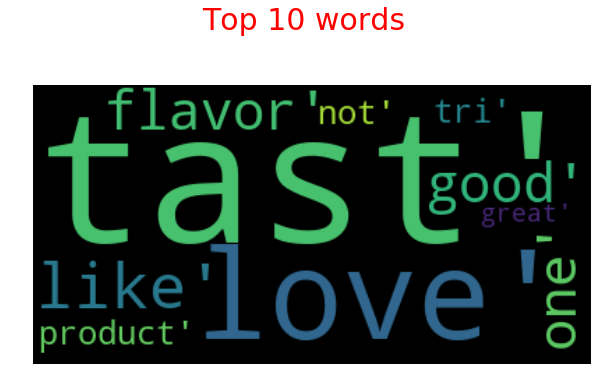

In [23]:
plt.figure(figsize=(10,8))
wc = WordCloud(background_color="black",max_font_size=150)
wc.generate(str(top10))
plt.imshow(wc, interpolation='bilinear')
plt.suptitle('Top 10 words', size=30, y=0.88,color="r"); 
plt.axis("off")
plt.savefig("SentimentAnalysis/images/top10_words.png")
plt.show()

# 4. Modeling

## 4.1. Support Vector Classifier

In [24]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class.
'''
One approach to addressing imbalanced datasets is to oversample the minority class. 
The simplest approach involves duplicating examples in the minority class, 
although these examples don’t add any new information to the model. 
Instead, new examples can be synthesized from the existing examples
'''
sm = SMOTE(sampling_strategy='auto')
oversampled_trainX, oversampled_trainY = sm.fit_resample(reviews_train_tfidf,sentiment_train)

from collections import Counter
Counter(oversampled_trainY)

Counter({-1: 21612, 0: 21612, 1: 21612})

In [25]:
# Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, 
# so it has more flexibility in the choice of penalties and loss functions and should scale better to large 
# numbers of samples.
from sklearn.svm import LinearSVC
svc_model=LinearSVC(dual=False,max_iter=1000) # Prefer dual=False when n_samples > n_features.
svc_model.fit(oversampled_trainX,oversampled_trainY)
svc_predict=svc_model.predict(reviews_test_tfidf)
svc_f1=f1_score(sentiment_test,svc_predict,average="weighted")
print("F1 Score for SVM Linear: ",svc_f1)

F1 Score for SVM Linear:  0.7121971401354958


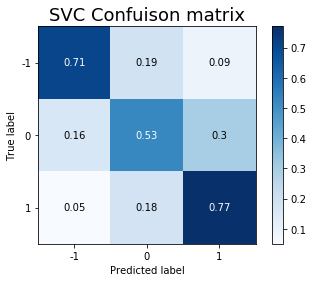

In [26]:
plot_confusion_matrix(sentiment_test,svc_predict,normalize=True)
#Classification accuracy alone can be misleading if you have an unequal number of observations in each class or 
#if you have more than two classes in your dataset.
plt.title("SVC Confuison matrix",size=18)
plt.show()

## 4.2. Decision Trees

In [27]:
from sklearn.tree import DecisionTreeClassifier
dt_param={'max_depth':[i for i in range(5,2000,3)],
         'min_samples_split':[i for i in range(5,2000,3)]}
dt_clf=DecisionTreeClassifier()
rndm_clf=RandomizedSearchCV(dt_clf,dt_param)
rndm_clf.fit(oversampled_trainX,oversampled_trainY)
dt_best_params=rndm_clf.best_params_

In [30]:
dt_best_params

{'max_depth': 1814, 'min_samples_split': 107}

In [31]:
dt_clf=DecisionTreeClassifier(**dt_best_params)
dt_clf.fit(oversampled_trainX,oversampled_trainY)
dt_predict=dt_clf.predict(reviews_test_tfidf)
dt_f1=f1_score(sentiment_test,svc_predict,average="weighted")
dt_f1

0.7121971401354958

Text(0.5, 1.0, 'Decision Tree Confuison matrix')

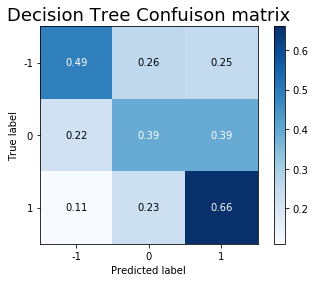

In [32]:
plot_confusion_matrix(sentiment_test,dt_predict,normalize=True)
plt.title("Decision Tree Confuison matrix",size=18)


## 4.3. Naive Bayes:

In [33]:
nb_params={"alpha":[10**i for i in range(-5,5)]}
nb_clf=MultinomialNB()
rndm_clf=RandomizedSearchCV(nb_clf,nb_params)
#rndm_clf.fit(oversampled_trainX,oversampled_trainY)
rndm_clf.fit(oversampled_trainX,oversampled_trainY)
nb_best_params=rndm_clf.best_params_

nb_clf=MultinomialNB(**nb_best_params)
nb_clf.fit(oversampled_trainX,oversampled_trainY)
nb_predict=nb_clf.predict(reviews_test_tfidf)
nb_f1=f1_score(sentiment_test,nb_predict,average="weighted")
nb_f1

0.7078701411560435

Text(0.5, 1.0, 'Naive Bayes Confusion Matrix')

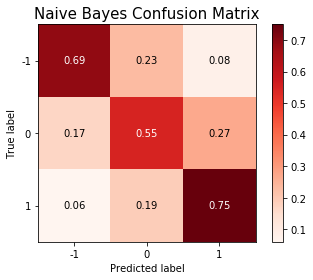

In [34]:
plot_confusion_matrix(sentiment_test,nb_predict,normalize=True,cmap="Reds")
plt.title("Naive Bayes Confusion Matrix",size=15)

## 4.4. Random Forrests

In [35]:
from sklearn.ensemble import RandomForestClassifier
param_rf={'max_depth':[2,3,4,5,6,7,8,9,10],'n_estimators':[i for i in range(1,1000,5)]}
clf=RandomForestClassifier()
rndm_clf=RandomizedSearchCV(clf,param_rf)
rndm_clf.fit(oversampled_trainX,oversampled_trainY)
rf_best_params=rndm_clf.best_params_
rf_best_params

{'max_depth': 9, 'n_estimators': 521}

In [36]:
rf_clf=RandomForestClassifier(**rf_best_params,class_weight='balanced')
rf_clf.fit(oversampled_trainX,oversampled_trainY)
rf_predict=rf_clf.predict(reviews_test_tfidf)

Text(0.5, 1.0, 'Random forrests Confusion Matrix')

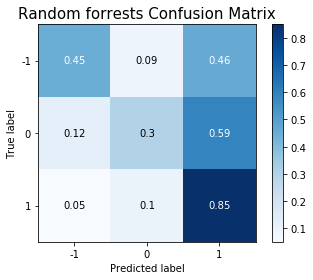

In [37]:
plot_confusion_matrix(sentiment_test,rf_predict,normalize=True)
plt.title("Random forrests Confusion Matrix",size=15)

In [38]:
rf_f1=f1_score(sentiment_test,rf_predict,average="weighted")
rf_f1

0.6402043825064386

# 5. Model evaluation:
    

In [39]:
models=["DecisionTrees","SVM","NaiveBayes","Random Forrests"]
f1_scores=[dt_f1,svc_f1,nb_f1,rf_f1]

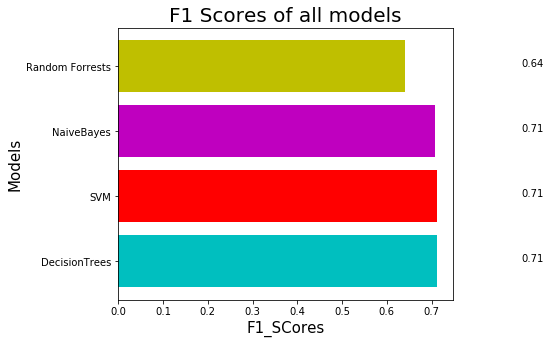

In [40]:
plt.figure(figsize=(6,5))
plt.barh(models,f1_scores,color=['c','r','m','y','b'])
plt.title("F1 Scores of all models",size=20)
for index, value in enumerate(f1_scores):
    plt.text(0.9,index,str(round(value,2)))
plt.xlabel('F1_SCores',size=15)
plt.ylabel("Models",size=15)
plt.savefig("f1_scores.png")
plt.show()


#### Obseravtions:
1. Almost all models have same f1_Score,except Random forrest being the least in the list.
2. After cross checking the confusion matrices of above models, SVC is slightly better than rest of the models. 
3. We will select SVC for our problem, lets Pickle the model for later use.

In [41]:
# lets save the model
import pickle
pickle.dump(svc_model,open("SentimentAnalysis/svc_model.pkl","wb"))
pickle.dump(tfidf_model,open("SentimentAnalysis/inverse_document_frequency_model.pkl","wb"))